In [1]:
import os
import sys
sys.path.append('/home/user/Desktop/Thesis_Scripts/Modules')

from Tkinter import *
import Tkinter, Tkconstants, tkFileDialog
import Import_module as im
import Filtering_module as fm

import numpy as np 
import math
import time

from h5py import File

import matplotlib
matplotlib.use('TkAgg') #Not case-sensitive
#%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
'''
import holoviews as hv
import datashader as ds
from holoviews.operation.datashader import datashade
import datashader.transfer_functions as tf
hv.extension('bokeh')
'''

"\nimport holoviews as hv\nimport datashader as ds\nfrom holoviews.operation.datashader import datashade\nimport datashader.transfer_functions as tf\nhv.extension('bokeh')\n"

In [ ]:
### Explore stimulation artifacts without PDMS

### Thesis: /home/user/Desktop/Data/2018-7-6/2344/Stimulation_13307/stimulation_el_13307_amp_100_phase_020.raw.h5

In [2]:
#Let the user select a dataset and open the h5 file

root = Tk()
root.withdraw()#Remove the root window from the screen without removing it
path = tkFileDialog.askopenfilename(initialdir = "/home/user/Desktop/Data")
root.destroy()
print path

/home/user/Desktop/Data/2018-7-6/2344/Stimulation_13307/stimulation_el_13307_amp_100_phase_020.raw.h5


In [207]:
root = Tk()
root.withdraw()
path = tkFileDialog.askdirectory(initialdir = "/home/user/Desktop/Data")
root.destroy()
print path

/home/user/Desktop/Data/2018-4-16/1912/Stimulation


In [3]:
raw = im.import_rawdata(path,0,'end',modified=False)

In [4]:
filtdat = fm.Filtering(raw)
filtdat.butter_filter(300,3000)
filtdat.discard_out_of_bounds()
raw = None

Discarded 10.0 traces.
0.0 critical traces.


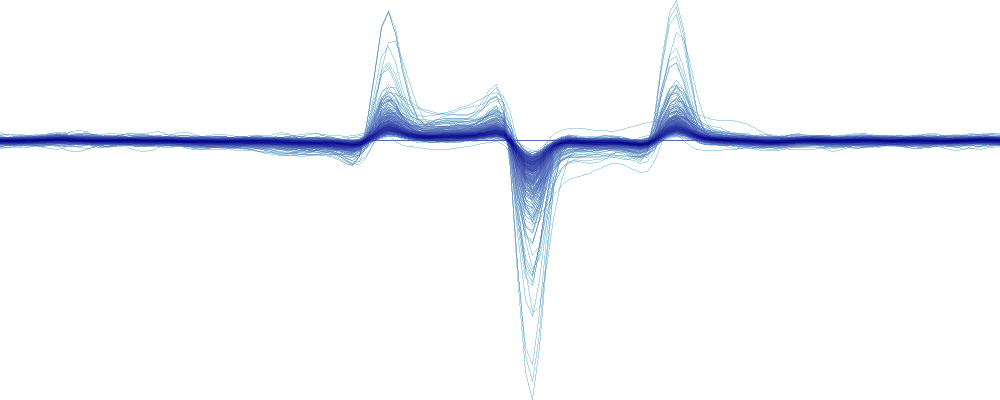

In [246]:
#Show all curves
i=0
start = DAC_changes[i]-50
stop = DAC_changes[i+2]+50
d0 = ds.utils.dataframe_from_multiple_sequences(filtdat.metadata['time'][start:stop],filtdat.butter_data[:,start:stop])
cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(d0, 'x', 'y', ds.count())   
img0 = tf.shade(agg, how='eq_hist')
img0

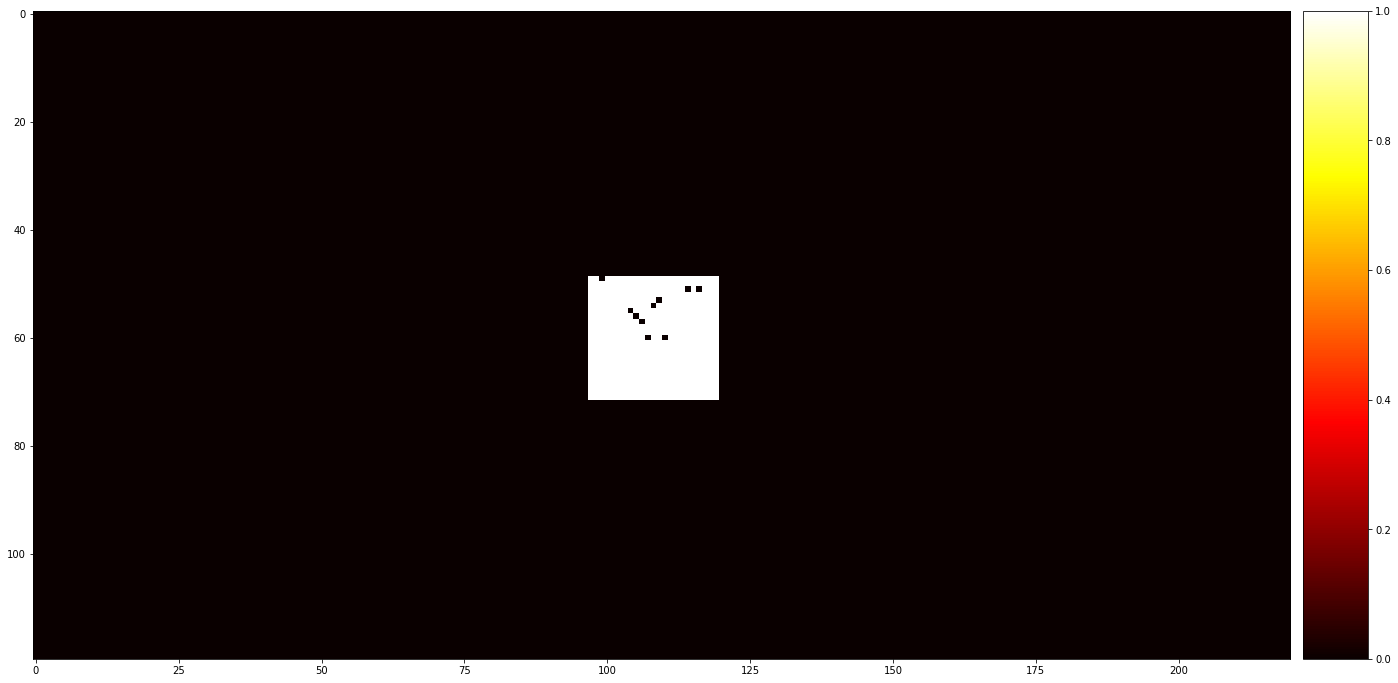

In [5]:
el_array = filtdat.metadata['electrode_map']
fig=plt.figure(figsize=(18,9))
ax=fig.add_axes([0,0,0.97,1])
#ax=fig.add_subplot(111)
i = ax.imshow(el_array,aspect='auto',cmap='hot',interpolation='none')
colorbar_ax = fig.add_axes([0.98,0,0.05,1])#Place colorbar next to el_array
#ax.set_axis_off() #Disable the axis labels
fig.colorbar(i,cax=colorbar_ax)

[712 732 752]


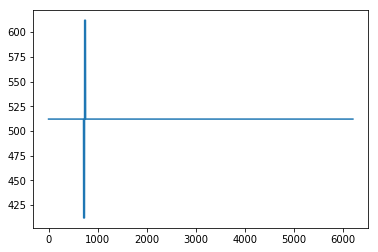

In [6]:
#Plot the DAC trace and find the indeces of the pulse
plt.plot(filtdat.metadata['DAC'])
DAC_changes = np.where(np.diff(filtdat.metadata['DAC'])!=0)[0]
print DAC_changes

In [7]:
#Locate the center electrode
center_el=13307
ind_cent=np.where(filtdat.metadata['clean_abs_inds']==center_el)[0]
center_x = filtdat.metadata['x_clean'][ind_cent]
center_y = filtdat.metadata['y_clean'][ind_cent]
print center_x,center_y

[107] [60]


In [9]:
#Replace by zero trace
filtdat.butter_data[ind_tokill[0]]=np.zeros((1,filtdat.butter_data.shape[1]))

NameError: name 'ind_tokill' is not defined

In [8]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
plt.rc('text', usetex=True)

### /home/user/Desktop/Data/2018-7-6/2344/Stimulation_13307/stimulation_el_13307_amp_100_phase_020.raw.h5

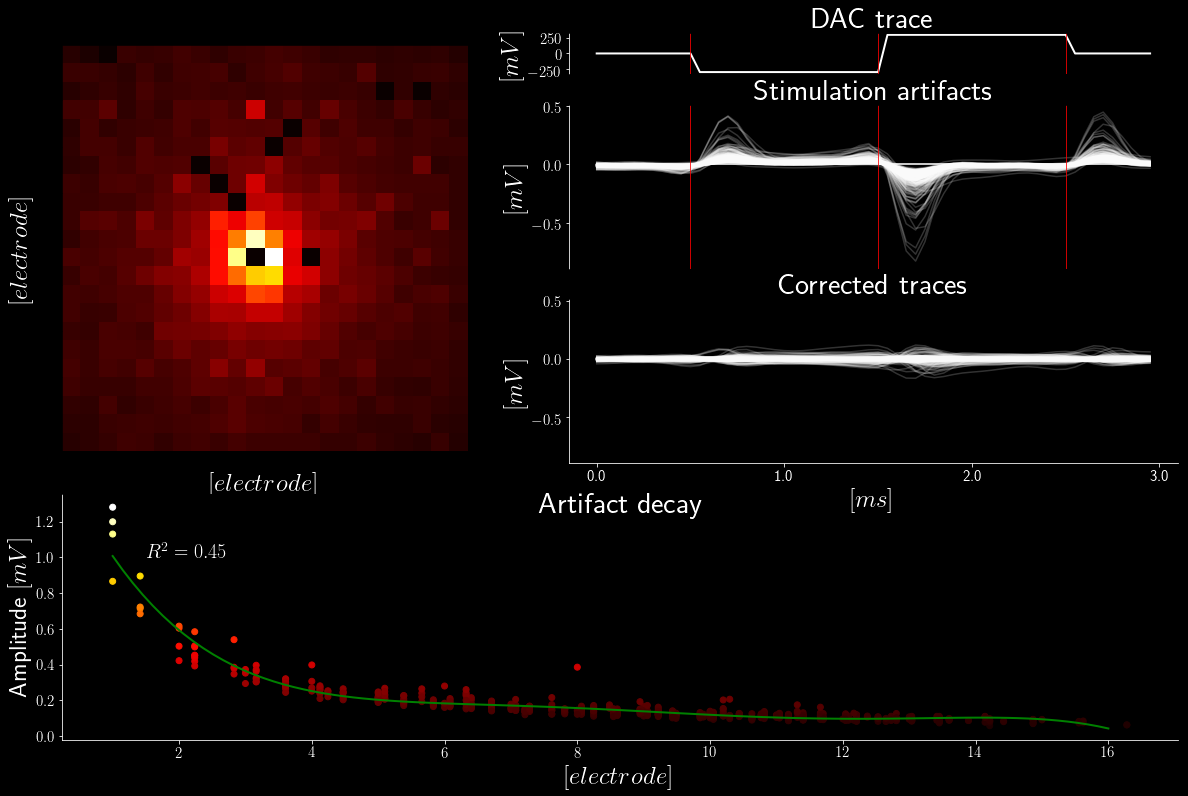

In [13]:
# Add corrected trace to the curve

fig = plt.figure(figsize=(20,13),facecolor='k')
gs = GridSpec(4,2,height_ratios=[1,4,4,6],width_ratios=[2,3])
ax1 = plt.subplot(gs[:3,0])
ax2 = plt.subplot(gs[3,:],facecolor='k')
ax3 = plt.subplot(gs[0,1],facecolor='k')
ax4 = plt.subplot(gs[1,1],facecolor='k')
ax5 = plt.subplot(gs[2,1],facecolor='k')

start= DAC_changes[0]-10
end = DAC_changes[2]+10
amps=[]
dists=[]

#Plot all traces to ax3 and scatter the distance to ax2
for i,j in enumerate(filtdat.butter_data):    
    ax4.plot(j[start:end]*0.00629,alpha=0.2,color='w')
    amp = np.max(j[start:end])-np.min(j[start:end])
    if i not in filtdat.metadata['Out_of_bounds']:
        dist_x = filtdat.metadata['x_clean'][i]-center_x
        dist_y = filtdat.metadata['y_clean'][i]-center_y
        dist = np.sqrt(np.power(dist_x,2)+np.power(dist_y,2))[0]
        amps.append(amp)
        dists.append(dist)
        x,y=filtdat.metadata['x_clean'][i],filtdat.metadata['y_clean'][i]
        filtdat.metadata['electrode_map'][y,x]=amp
        
ax2.scatter(np.asarray(dists),np.asarray(amps)*0.00629,c=amps,cmap='hot',vmin=3)
z = np.polyfit(np.asarray(dists),np.asarray(amps),5)
p = np.poly1d(z)
xp = np.linspace(1,16,100)
ax2.plot(xp,p(xp)*0.00629,'-',color='g',linewidth=2)
#Calculate goodness of fit
y_mean = np.sum(np.asarray(amps)*0.00629)/len(amps)
ssreg = np.sum((p(xp)*0.00629-y_mean)**2)
sstot = np.sum((np.asarray(amps)*0.00629 - y_mean)**2)
r_squared = ssreg / sstot
ax2.text(1.5,1,'$R^2={:.2f}$'.format(r_squared),color='w',fontsize=20)

#Calculate the the corrected trace
mean_trace = np.mean(filtdat.butter_data[:,start:end],axis=0) #Calculate the mean trace
mean_amp = np.max(mean_trace)-np.min(mean_trace) #and the ampltide of that mean trace

for i,j in enumerate(np.delete(filtdat.butter_data,filtdat.metadata['Out_of_bounds'],axis=0)):
    pred_amp = p(dists[i])
    factor = pred_amp/mean_amp #factor which is multiplied with the mean_trace
    appr = mean_trace*factor
    corr = j[start:end]-appr #Subtract the approxiamted trace
    ax5.plot(corr*0.00629,color='w',alpha=0.2)
    
ax5.set_title(r'Corrected traces',fontsize=30,color='w')
ax5.set_ylabel(r'$[mV]$',fontsize=25,color='w')
ax5.set_xticks(np.linspace(0,60,4))
ax5.set_xticklabels(np.linspace(0,60*0.05,4))
ax5.set_xlabel(r'$[ms]$',fontsize=25,color='w')
ax5.tick_params(axis='both',color='w',labelcolor='w',labelsize=15)
ax5.spines['left'].set_color('w')
ax5.spines['bottom'].set_color('w')
ax5.set_ylim(ax4.get_ylim())


ax4.set_ylabel(r'$[mV]$',fontsize=25,color='w')
ax4.xaxis.set_visible(False)
ax4.set_title(r'Stimulation artifacts',fontsize=30,color='w')
ax4.tick_params(axis='y',color='w',labelcolor='w',labelsize=15)
ax4.spines['left'].set_color('w')

ax2.set_title(r'Artifact decay',fontsize=30,color='w',y=0.9)
ax2.set_xlabel(r'$[electrode]$',fontsize=25,color='w')
ax2.set_ylabel(r'Amplitude $[mV]$',fontsize=25,color='w')
ax2.tick_params(axis='both',color='w',labelcolor='w',labelsize=15)
ax2.spines['left'].set_color('w')
ax2.spines['bottom'].set_color('w')

#Plot the DAC trace
DAC_mv = (filtdat.metadata['DAC'][start:end]-512.)*2.92
ax3.plot(DAC_mv,color='w',linewidth=2)

ax3.set_title(r'DAC trace',fontsize=30,color='w')
ax3.set_ylabel(r'$[mV]$',fontsize=25,color='w')
ax3.xaxis.set_visible(False)
ax3.tick_params(axis='y',color='w',labelcolor='w',labelsize=15)
ax3.spines['left'].set_color('w')

#Add some lines
line_1 = DAC_changes[0]-start
line_2 = DAC_changes[1]-start
line_3 = DAC_changes[2]-start

ax3.axvline(x=line_1,color='r',linewidth=0.8)
ax4.axvline(x=line_1,color='r',linewidth=0.8)
ax3.axvline(x=line_2,color='r',linewidth=0.8)
ax4.axvline(x=line_2,color='r',linewidth=0.8)
ax3.axvline(x=line_3,color='r',linewidth=0.8)
ax4.axvline(x=line_3,color='r',linewidth=0.8)

#Plot the routed electrodes to ax1
x_range = [np.min(filtdat.metadata['x_clean']),np.max(filtdat.metadata['x_clean'])]
y_range = [np.min(filtdat.metadata['y_clean']),np.max(filtdat.metadata['y_clean'])]

ax1.imshow(filtdat.metadata['electrode_map'][y_range[0]:y_range[1],x_range[0]:x_range[1]],cmap='hot',vmin=3)
ax1.set_xlabel(r'$[electrode]$',fontsize=25,color='w')
ax1.set_ylabel(r'$[electrode]$',fontsize=25,color='w')

newpath = ('/').join(path.split('/')[:-1])
plt.savefig(newpath+'/stimulus_artefacts_thesis'+'.png',dpi=600,bbox_inches='tight',pad_inches=0.2, facecolor=fig.get_facecolor(), edgecolor='none')

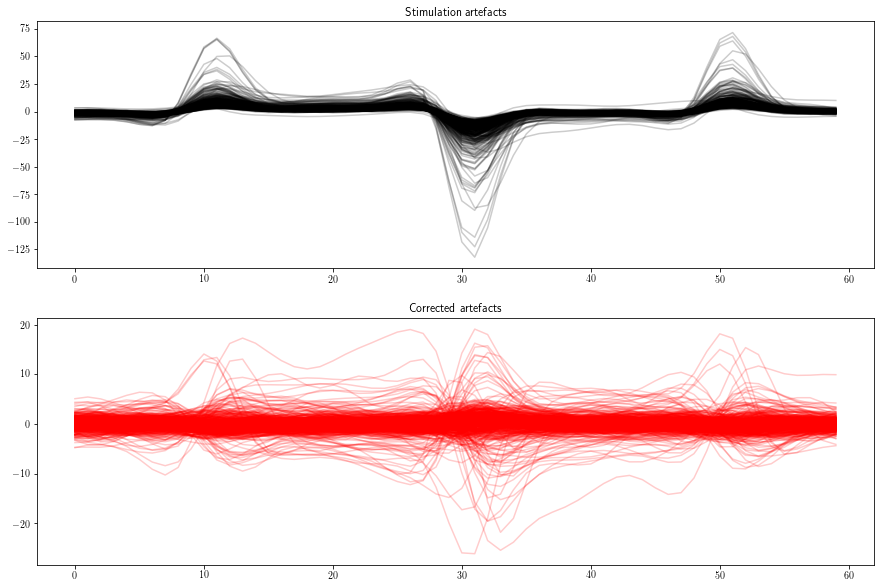

In [261]:
#Use mean curve and predicted amp from fit
start = 705
end = 765

mean_trace = np.mean(filtdat.butter_data[:,start:end],axis=0)
mean_amp = np.max(mean_trace)-np.min(mean_trace)

num_ver_plot=2
num_hor_plot=1
fig,axarr=plt.subplots(num_ver_plot,num_hor_plot,figsize=(15,10))
for i,j in enumerate(filtdat.butter_data):
    if i not in filtdat.metadata['Out_of_bounds']:
        dist_x = filtdat.metadata['x_clean'][i]-center_x
        dist_y = filtdat.metadata['y_clean'][i]-center_y
        dist = np.sqrt(np.power(dist_x,2)+np.power(dist_y,2))[0]

        axarr[0].plot(j[start:end],alpha=0.2,color='k')
        pred_amp = p(dist)
        factor = pred_amp/mean_amp
        appr = mean_trace*factor
        corr = j[start:end]-appr
        corr_amp = np.max(corr)-np.min(corr)
        axarr[1].plot(corr,color='r',alpha=0.2)
    
    
axarr[0].set_title('Stimulation artefacts')
axarr[1].set_title('Corrected artefacts')

#newpath = ('/').join(path.split('/')[:-1])
#plt.savefig(newpath+'/corrected_artefacts.png',bbox_inches='tight',pad_inches=0)

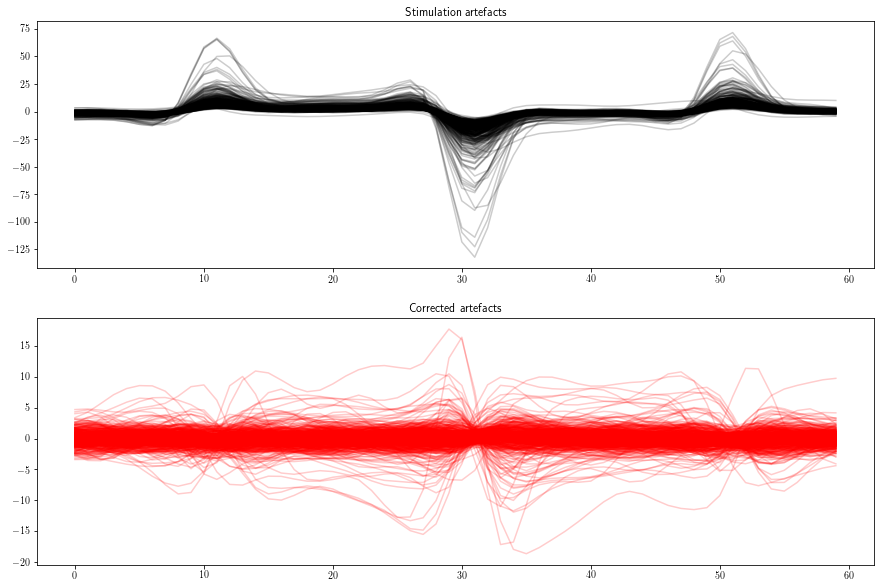

In [85]:
#Use mean curve and amp of each trace
start = 705
end = 765

mean_trace = np.mean(filtdat.butter_data[:,start:end],axis=0)
mean_amp = np.max(mean_trace)-np.min(mean_trace)

num_ver_plot=2
num_hor_plot=1
fig,axarr=plt.subplots(num_ver_plot,num_hor_plot,figsize=(15,10))
for i in filtdat.butter_data:
    amp = np.max(i[start:end])-np.min(i[start:end])
    if amp>0:
        axarr[0].plot(i[start:end],alpha=0.2,color='k')
        factor = amp/mean_amp
        appr = mean_trace*factor
        corr = i[start:end]-appr
        axarr[1].plot(corr,color='r',alpha=0.2)
    
    
axarr[0].set_title('Stimulation artefacts')
axarr[1].set_title('Corrected artefacts')

#newpath = ('/').join(path.split('/')[:-1])
#plt.savefig(newpath+'/corrected_artefacts.png',bbox_inches='tight',pad_inches=0)

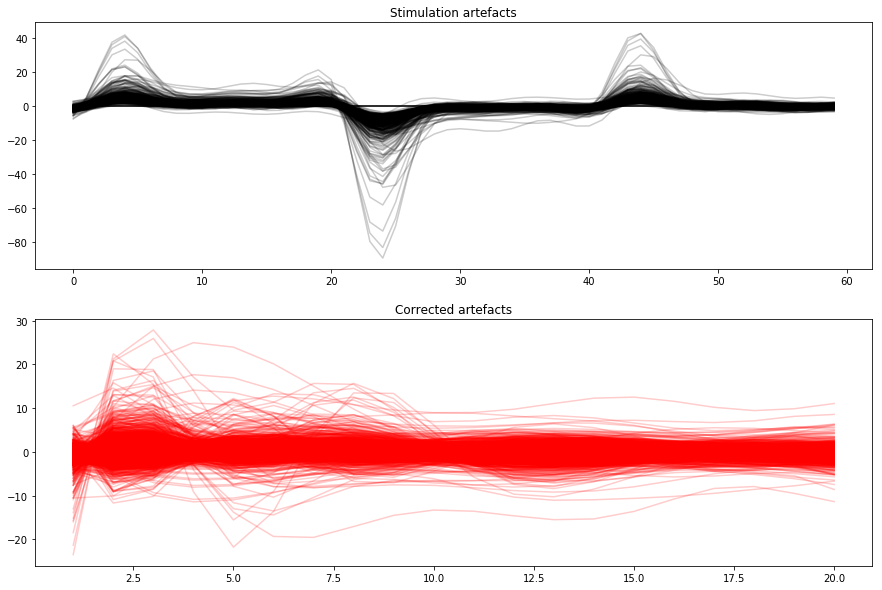

In [155]:
#Fit a polynomial on biggest curve
max_ind = np.argmax(amps)
fit_size = 20

t1,t2,t3 = DAC_changes

x1 = np.linspace(1,t2-t1,t2-t1)
y1 = filtdat.butter_data[max_ind,t1:t2]
p1 = np.poly1d(np.polyfit(x1,y1,5))

x2 = np.linspace(1,t3-t2,t3-t2)
y2 = filtdat.butter_data[max_ind,t2:t3]
p2 = np.poly1d(np.polyfit(x2,y2,5))

x3 = np.linspace(1,fit_size,fit_size)
y3 = filtdat.butter_data[max_ind,t3:t3+fit_size]
p3 = np.poly1d(np.polyfit(x3,y3,5))


num_ver_plot=2
num_hor_plot=1
fig,axarr=plt.subplots(num_ver_plot,num_hor_plot,figsize=(15,10))
for j,i in enumerate(filtdat.butter_data):
    axarr[0].plot(i[t1:t3+fit_size],alpha=0.2,color='k')
    
    fit_1 = p1(x)/dists[j]
    corr_1 = i[t1:t1+fit_size]-fit_1
    axarr[1].plot(x,corr_1,color='r',alpha=0.2)
    
    fit_2 = p2(x)/dists[j]
    corr_2 = i[t2:t2+fit_size]-fit_2
    axarr[1].plot(x,corr_2,color='r',alpha=0.2)
    
    fit_3 = p3(x)/dists[j]
    corr_3 = i[t3:t3+fit_size]-fit_3
    axarr[1].plot(x,corr_3,color='r',alpha=0.2)
    
    
    
axarr[0].set_title('Stimulation artefacts')
axarr[1].set_title('Corrected artefacts')

newpath = ('/').join(path.split('/')[:-1])
plt.savefig(newpath+'/corrected_artefacts.png',bbox_inches='tight',pad_inches=0)

In [61]:
#Interactive datashader plot
%opts RGB [width=950,height=400]
trace_curve_butter_average = hv.Curve((filtdat.metadata['time'][0:10000],filtdat.butter_data[538,0:10000]),'seconds [s]','bits')
datashade(trace_curve_butter_average,cmap=['blue'])

:DynamicMap   []

In [9]:
#Multiple recordings: Calculate the amplitude of each trace
#amps=[np.amax(j,axis=1)-np.amin(j,axis=1) for j in traces]
timestamp=100
amps=[j[:,timestamp] for j in traces]
min_val=[np.median(j[j!=0]) for j in traces]
max_val=[np.max(j) for j in traces]

offset_x=[np.min(i) for i in xs_clean]
offset_y=[np.min(i) for i in ys_clean]
span_x = [np.max(i)-np.min(i) for i in xs_clean]
span_y = [np.max(i)-np.min(i) for i in ys_clean]


amps=[j[:,timestamp] for j in traces]

matrix=[None]*len(amps)
for i in range(len(amps)):
    matrix[i] = np.zeros((span_y[i]+1,span_x[i]+1))
    matrix[i][ys_clean[i]-offset_y[i],xs_clean[i]-offset_x[i]]=amps[i]

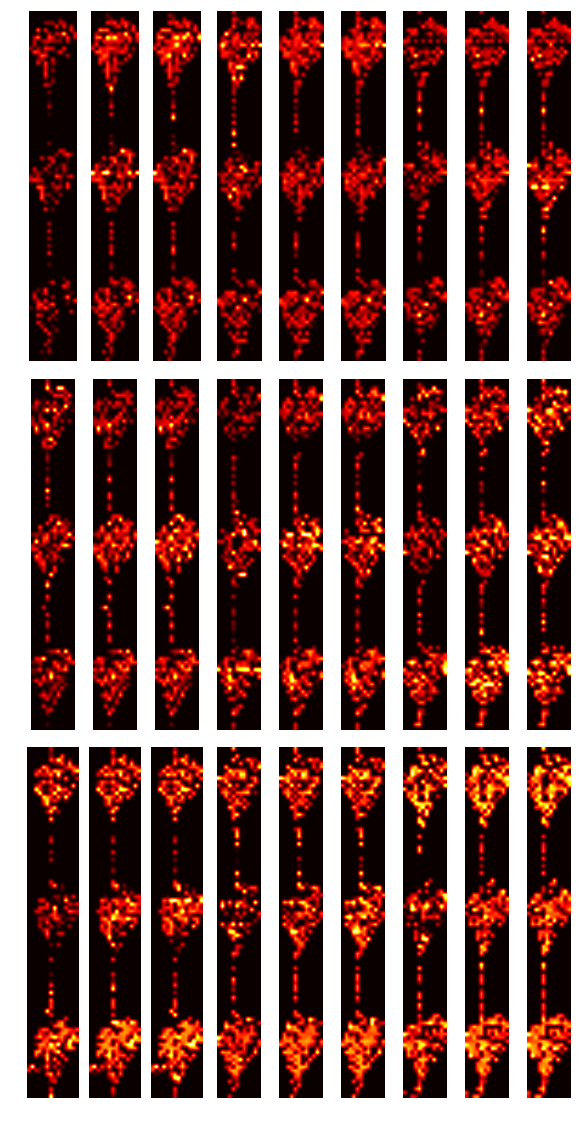

In [10]:
fig,axarray=plt.subplots(3,9,figsize=(10,20))
for i in range(3):
    for j in range(9):
        axarray[i,j].imshow(matrix[i*9+j],cmap='hot',vmin=0,vmax=max_val[j],origin='lower',interpolation='bilinear')
        axarray[i,j].set_axis_off()
plt.subplots_adjust(wspace=0.,hspace=0.05)

In [13]:
#Calculate the maximal amplitude in each timestep over all traces in all recordings: For multiple h5files

max_vals=[]
timestamp=np.arange(0,11000,20) #every 20 time entry
for t in range(len(timestamp)-1):
    max_vals.append([np.max(np.max(j[:,timestamp[t]:timestamp[t+1]],axis=1)-np.min(j[:,timestamp[t]:timestamp[t+1]],axis=1)) for j in filtdat.butter_data])
maximum_timepiece_diffs=np.asarray(max_vals).T

for el in maximum_timepiece_diffs[:200]:
    plt.plot(el)
print np.mean(maximum_timepiece_diffs)

IndexError: too many indices for array

111.501902


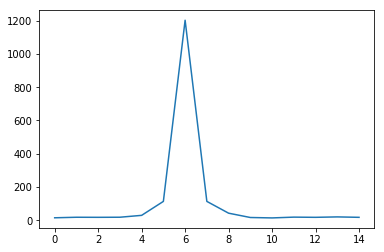

In [61]:
#Calculate the maximal amplitude in each timestep over all traces in all recordings: For one h5 file
i = 19
max_vals=[]

timestamp=np.arange(1200,2000,50) #every 20 time entry
for t in range(len(timestamp)-1):
    max_vals.append(np.max(np.max(filtdat.butter_data[i][:,timestamp[t]:timestamp[t+1]],axis=1)-np.min(filtdat.butter_data[i][:,timestamp[t]:timestamp[t+1]],axis=1)))
maximum_timepiece_diffs=np.asarray(max_vals)

print np.mean(maximum_timepiece_diffs)
plt.plot(maximum_timepiece_diffs)

50.9491195633


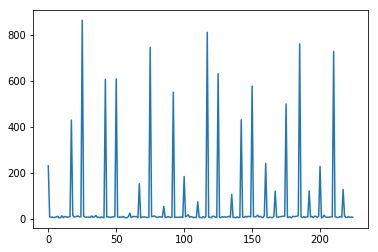

In [65]:
#Calculate the maximal amplitude in each timestep over all traces in all recordings: For one h5 file
max_vals=[]
timestamp=np.arange(1300,1350,5) #every 20 time entry
for t in range(len(timestamp)-1):
    for i in filtdat.butter_data:
        max_vals.append(np.max(np.max(i[:,timestamp[t]:timestamp[t+1]],axis=1)-np.min(i[:,timestamp[t]:timestamp[t+1]],axis=1)))
maximum_timepiece_diffs=np.asarray(max_vals)

print np.mean(maximum_timepiece_diffs)
plt.plot(maximum_timepiece_diffs)

In [12]:
#Calculate the maximal amplitude in each timestep over all traces in one recording
max_vals=[]
timestamp=np.arange(0,cut_data_butter.shape[1],50)
for t in range(len(timestamp)-1):
    max_vals.append(np.max(np.max(cut_data_butter[:,timestamp[t]:timestamp[t+1]],axis=1)-np.min(cut_data_butter[:,timestamp[t]:timestamp[t+1]],axis=1)))
maximum_timepiece_diffs=np.asarray(max_vals)

plt.plot(maximum_timepiece_diffs[:2000])
print np.mean(maximum_timepiece_diffs)

NameError: name 'cut_data_butter' is not defined

In [46]:
#One recording
offset_x = np.min(filtdat.metadata[0]['x_clean'])
offset_y = np.min(filtdat.metadata[0]['y_clean'])
span_x = np.max(filtdat.metadata[-1]['x_clean'])-np.min(filtdat.metadata[0]['x_clean'])
span_y = np.max(filtdat.metadata[-1]['y_clean'])-np.min(filtdat.metadata[0]['y_clean'])

matrix = np.zeros((span_y+1,span_x+1))

timestamp=np.arange(1400,1800,2)
for t in range(len(timestamp)-1):
    for j,i in enumerate(filtdat.metadata):
        amps = np.max(filtdat.butter_data[j][:,timestamp[t]:timestamp[t+1]],axis=1)-np.min(filtdat.butter_data[j][:,timestamp[t]:timestamp[t+1]],axis=1)
        matrix[i['y_clean']-np.min(i['y_clean']),i['x_clean']-np.min(i['x_clean'])] = amps
    fig=plt.figure(figsize=(span_x/2,span_y/2))
    ax=fig.add_subplot(111)
    ax.imshow(matrix,cmap='hot',vmin=0, vmax=(np.mean(maximum_timepiece_diffs)),origin='lower')
    ax.set_axis_off()
    plt.savefig(path+'/'+str(t)+'.png',bbox_inches='tight',pad_inches=0)
    plt.close()

In [66]:
#One recording
offset_x = np.min(filtdat.metadata[0]['x_clean'])
offset_y = np.min(filtdat.metadata[0]['y_clean'])
span_x = np.max(filtdat.metadata[-1]['x_clean'])-np.min(filtdat.metadata[0]['x_clean'])
span_y = np.max(filtdat.metadata[-1]['y_clean'])-np.min(filtdat.metadata[0]['y_clean'])

matrix = np.zeros((span_y+1,span_x+1))

timestamp=np.arange(1300,1350,5)
for t in range(len(timestamp)-1):
    for j,i in enumerate(filtdat.metadata):
        amps = np.max(filtdat.butter_data[j][:,timestamp[t]:timestamp[t+1]],axis=1)-np.min(filtdat.butter_data[j][:,timestamp[t]:timestamp[t+1]],axis=1)
        matrix[i['y_clean'],i['x_clean']] = amps
    fig=plt.figure(figsize=(span_x/2,span_y/2))
    ax=fig.add_subplot(111)
    ax.imshow(matrix,cmap='hot',vmin=0,vmax=(np.mean(maximum_timepiece_diffs)),origin='lower')
    ax.set_axis_off()
    plt.savefig(path+'/'+str(t)+'.png',bbox_inches='tight',pad_inches=0)
    plt.close()

In [6]:
for i in range(64):
    os.rename(path+'/'+str(i)+'_.png',path+'/'+str(i+44)+'.png')

In [20]:
#Multiple recordings
from itertools import product
offset_x=[np.min(i) for i in xs_clean]
offset_y=[np.min(i) for i in ys_clean]
span_x = [np.max(i)-np.min(i) for i in xs_clean]
span_y = [np.max(i)-np.min(i) for i in ys_clean]

timestamp=np.arange(0,11000,20) #every 20 time entry
for t in range(len(timestamp)-1):
    #Amps contains a vector with the maximal aplitude in each trace in one timestep
    amps=[np.max(j[:,timestamp[t]:timestamp[t+1]],axis=1)-np.min(j[:,timestamp[t]:timestamp[t+1]],axis=1) for j in traces]
    matrix=[None]*len(amps)
    for i in range(len(amps)):
        matrix[i] = np.zeros((span_y[i]+1,span_x[i]+1))
        matrix[i][ys_clean[i]-offset_y[i],xs_clean[i]-offset_x[i]]=amps[i]

    fig,axarray=plt.subplots(3,9,figsize=(10,10))
    for k,(i,j) in list(enumerate(product(range(3),range(9)))):
        #The highest value is the mean amplitude/difference over all traces: maximum_timepiece_diffs
        axarray[i,j].imshow(matrix[k],cmap='hot',vmin=0,vmax=np.mean(maximum_timepiece_diffs),origin='lower',interpolation='bilinear')
        axarray[i,j].set_axis_off()
    plt.savefig('/home/user/Desktop/Data/2018-1-25/1629/stimulus_visualization/'+str(t)+'.png',bbox_inches='tight',pad_inches=0)
    plt.close()

In [256]:
%%output size=200
%%opts Image [colorbar=True height=400 width=400]
img=hv.Image(matrix)
img

:Image   [x,y]   (z)

In [257]:
%%output size=200
%%opts HeatMap [colorbar=True height=300 width=300 tools=['hover']]
data=zip(ys_clean,xs_clean,amps)
heatmap = hv.HeatMap(sorted(data))
heatmap

:HeatMap   [x,y]   (z)

In [221]:
#Mean value of each trace
means=np.mean(traces,axis=1,dtype=np.float64)
means_rep=np.transpose(np.tile(means,(200,1)))
print means.view(), means.shape
stdev=np.std(traces,axis=1,dtype=np.float64)
stdev_rep=np.transpose(np.tile(stdev,(200,1)))
print stdev.view(), stdev.shape

[ 465.9265   460.0725   460.8308   457.38305  452.05675  453.6964   449.5089
  446.65455  446.28095  441.33535  444.5956   437.7133   441.1217
  435.60815  438.8563   441.75625  433.346    435.2955   430.1091 ] (19,)
[ 1.40843805  1.96828447  1.93787806  2.28114504  1.44153718  1.55785976
  1.59487328  1.58660464  1.59950527  2.18096088  2.23355337  1.58455139
  1.44446845  1.44471574  2.73836636  2.96031011  2.29771278  1.84647766
  1.40142684] (19,)


In [222]:
peaks = [np.where(i==np.amin(i))[0][0] for i in traces]
print peaks, type(peaks)

[3001, 2681, 2920, 2918, 2879, 2613, 3075, 2692, 2897, 3153, 2969, 2660, 3068, 3132, 2870, 3076, 3191, 2698, 3226] <type 'list'>


In [223]:
'''
Crop the data around the peaks using a normal for loop:
------------------------------------------------
pulses=[]
for i in range(len(traces)):
    pulses.append(traces[i,peaks[i]-100:peaks[i]+100])
-------------------------------------------------
or in numpy:
pulses=np.empty((19,100))
for i in range(len(traces)):
    pulses[i]=(traces[i,peaks[i]-100:peaks[i]+100])
-------------------------------------------------
or a list comprehension:
'''
pulses = [traces[i,peaks[i]-10:peaks[i]+190] for i in range(len(traces))]
pulses_stand=np.true_divide(np.subtract(pulses,means_rep),stdev_rep)
print pulses_stand.view(), pulses_stand.shape

[[-0.65782091 -1.36782729 -1.36782729 ...,  0.76219185  0.05218547
   0.05218547]
 [ 2.50344911  1.99539247  1.99539247 ...,  0.47122254  0.47122254
  -0.03683411]
 [-0.42871635 -0.42871635  0.087312   ...,  0.087312    0.087312
   0.60334034]
 ..., 
 [-1.89144616 -1.89144616 -1.45623075 ..., -1.45623075 -1.45623075
  -1.89144616]
 [ 1.4646806   1.4646806   1.4646806  ...,  3.08939562  3.08939562
   2.54782395]
 [-0.07784923 -0.07784923 -0.07784923 ..., -1.50496618 -2.21852466
   9.91196943]] (19, 200)


In [224]:
%%output size=150
%%opts Curve  [height=200 width=600 tools=['hover']]
%%opts Curve (color='red' line_width=1.5)

curve0 = hv.Curve((t[:200],pulses_stand[0,:200]),'seconds','bits')
curve1 = hv.Curve((t[:200],pulses_stand[4,:200]),'seconds','bits')
curve2 = hv.Curve((t[:200],pulses_stand[8,:200]),'seconds','bits')
curve3 = hv.Curve((t[:200],pulses_stand[12,:200]),'seconds','bits')

(curve0+curve1+curve2+curve3).cols(1)

:Layout
   .Curve.I   :Curve   [seconds]   (bits)
   .Curve.II  :Curve   [seconds]   (bits)
   .Curve.III :Curve   [seconds]   (bits)
   .Curve.IV  :Curve   [seconds]   (bits)

480.0 446.0


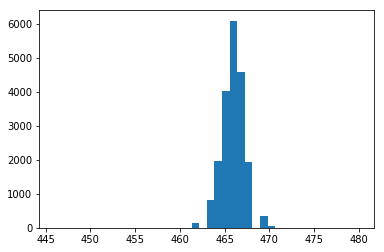

In [89]:
print np.amax(traces[0]), np.amin(traces[0]), means[0], stdev[0]
plt.hist(traces[0],bins=40)
plt.show
print np.amax(traces[0]), np.amin(traces[0])